In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("dirty_v3_path.csv").head(5000)

In [4]:
df.head()

,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,random_notes,noise_col
0,46.0,Male,Diabetes,137.04,135.27,28.90,96.04,6,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05,lorem,-137.057211
1,22.0,Male,Healthy,71.58,113.27,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,ipsum,-11.230610
2,50.0,NaN,Asthma,95.24,NaN,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,ipsum,98.331195
3,57.0,NaN,Obesity,NaN,130.53,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,lorem,44.187175
4,66.0,Female,Hypertension,95.15,178.17,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,lorem,44.831426


In [5]:
df = df.drop(columns=['random_notes', 'noise_col'])

In [6]:
df.shape

(5000, 18)

In [7]:
df.isna().sum()

Age                  727
Gender               745
Medical Condition    743
Glucose              750
Blood Pressure       722
BMI                    0
Oxygen Saturation      0
LengthOfStay           0
Cholesterol            0
Triglycerides          0
HbA1c                  0
Smoking                0
Alcohol                0
Physical Activity      0
Diet Score             0
Family History         0
Stress Level           0
Sleep Hours            0
dtype: int64

Chci predikovat medicinal condition, takže null hodnoty dropnu

In [8]:
df = df[~df['Medical Condition'].isna()]

In [9]:
df.shape

(4257, 18)

In [10]:
df.isna().sum()

Age                  621
Gender               636
Medical Condition      0
Glucose              627
Blood Pressure       622
BMI                    0
Oxygen Saturation      0
LengthOfStay           0
Cholesterol            0
Triglycerides          0
HbA1c                  0
Smoking                0
Alcohol                0
Physical Activity      0
Diet Score             0
Family History         0
Stress Level           0
Sleep Hours            0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4257 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                3636 non-null   float64
 1   Gender             3621 non-null   object 
 2   Medical Condition  4257 non-null   object 
 3   Glucose            3630 non-null   float64
 4   Blood Pressure     3635 non-null   float64
 5   BMI                4257 non-null   float64
 6   Oxygen Saturation  4257 non-null   float64
 7   LengthOfStay       4257 non-null   int64  
 8   Cholesterol        4257 non-null   float64
 9   Triglycerides      4257 non-null   float64
 10  HbA1c              4257 non-null   float64
 11  Smoking            4257 non-null   int64  
 12  Alcohol            4257 non-null   int64  
 13  Physical Activity  4257 non-null   float64
 14  Diet Score         4257 non-null   float64
 15  Family History     4257 non-null   int64  
 16  Stress Level       4257 non-n

In [12]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
df['Blood Pressure'] = df['Blood Pressure'].fillna(df['Blood Pressure'].mean())
df['Gender'] = df['Gender'].fillna('Unknown')

<Figure size 1200x600 with 0 Axes>

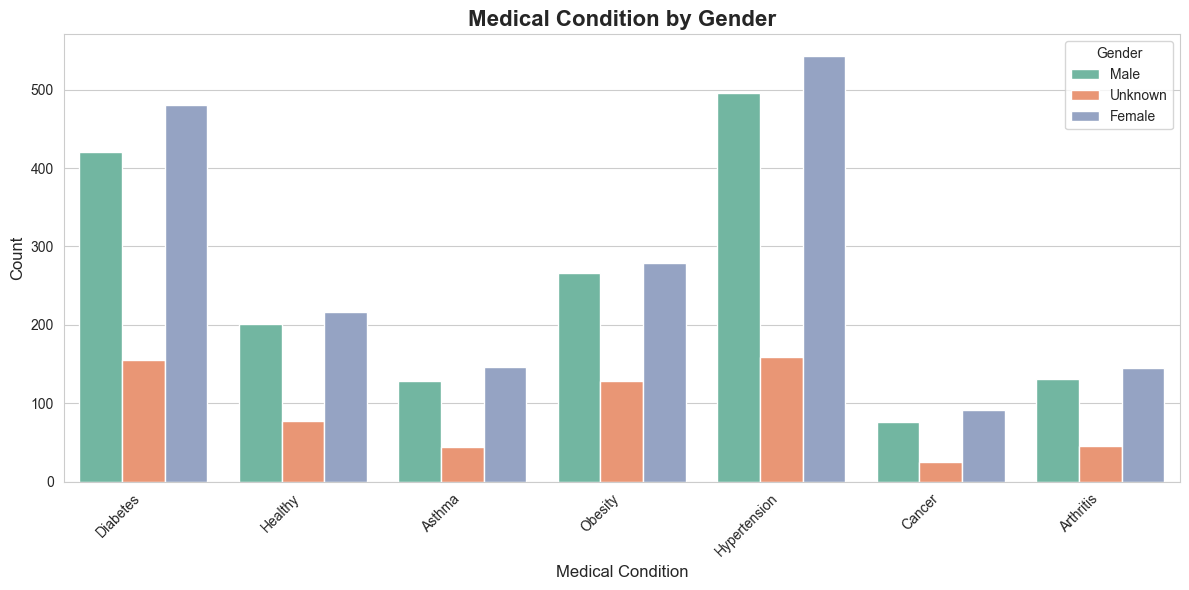

In [13]:
# Nastavení stylu
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Vytvoření crosstab pro počty
condition_gender = pd.crosstab(df['Medical Condition'], df['Gender'])

# Alternativně s seaborn pro hezčí vzhled:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Medical Condition', hue='Gender', palette='Set2')
plt.title('Medical Condition by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Medical Condition', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [14]:
df['Gender'].value_counts()

Gender
Female     1902
Male       1719
Unknown     636
Name: count, dtype: int64

Z grafu se nedá vyhodnotit, že by jedno pohlaví bylo více nemocné než druhé. Vyšší hodnoty u žen jsou způsobeny tím, že ženy jsou ve vzorku více zastoupeny.

Float sloupce: ['Age', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Physical Activity', 'Diet Score', 'Stress Level', 'Sleep Hours']


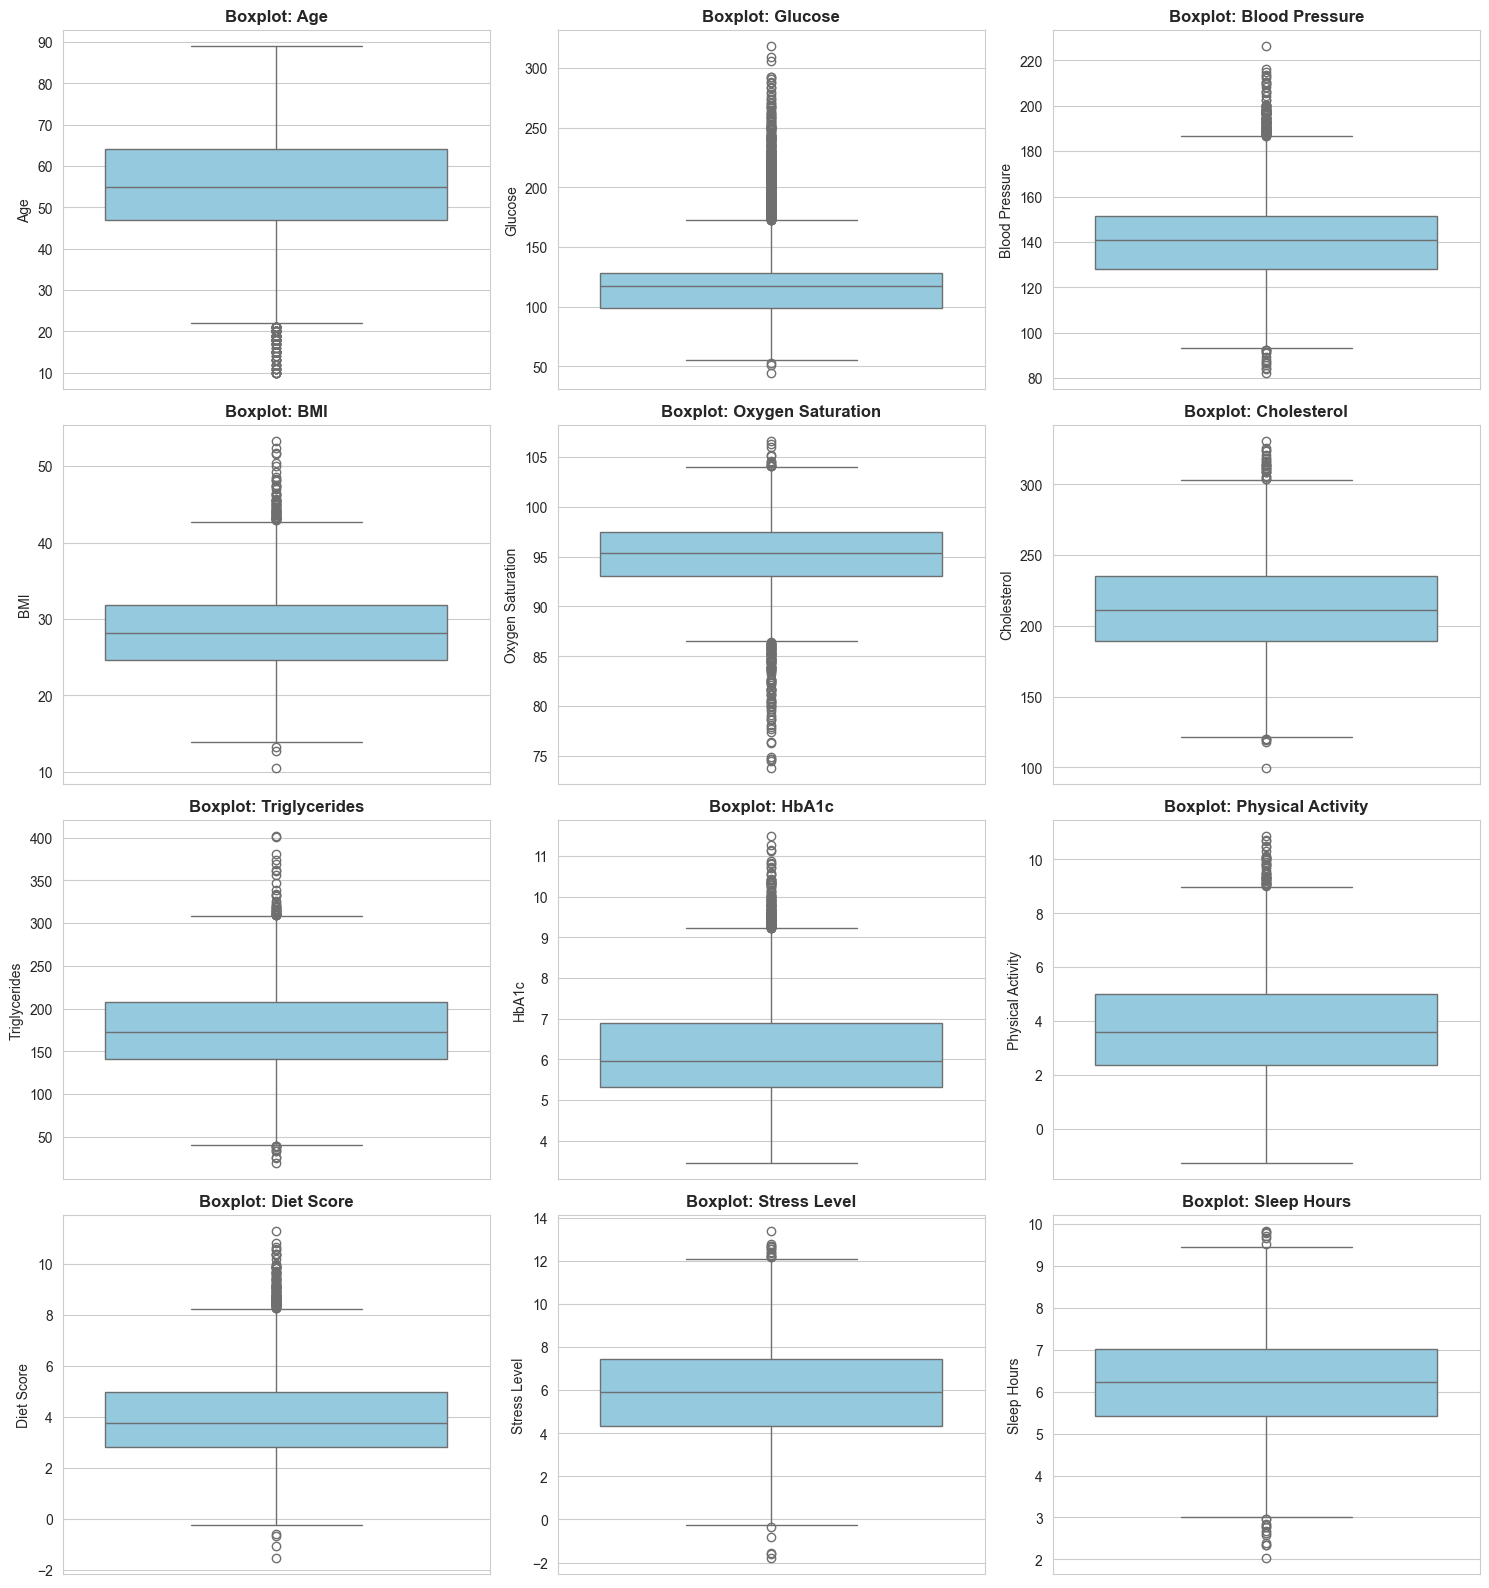

In [15]:
# Vyber všechny float sloupce
float_columns = df.select_dtypes(include=['float64']).columns.tolist()

print(f"Float sloupce: {float_columns}")

# Vytvoření boxplotů pro všechny float sloupce
n_cols = 3  # Počet sloupců v gridu
n_rows = (len(float_columns) + n_cols - 1) // n_cols  # Počet řádků

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Zploštění pro jednodušší iteraci

for i, col in enumerate(float_columns):
    sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(col, fontsize=10)

# Skrytí prázdných subplotů
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Průměrný jedinec datasetu naspí něco málo nad 6 hodin, není příliš fyzicky aktivní, jeho strava je podprůměrná, má nad 50 let a žije poměrně stresuplným životem.

V důsledku toho je zvýšený cholesterol a krevní tlak.

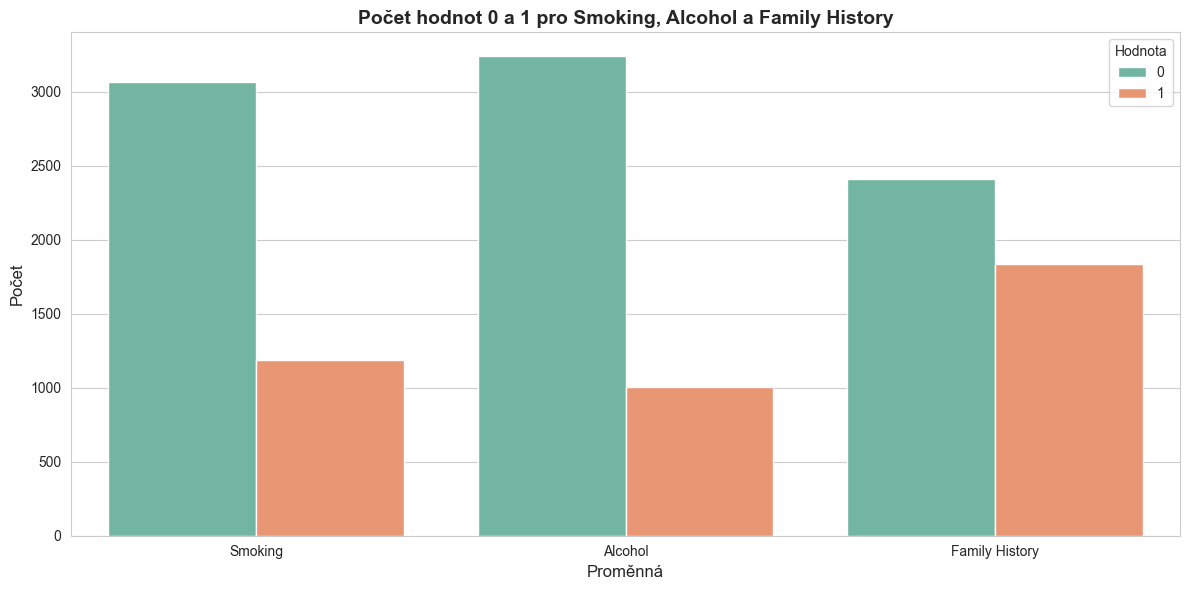

In [23]:
# Všechny tři proměnné vedle sebe
columns_to_plot = ['Smoking', 'Alcohol', 'Family History']

# Vytvoř data pro grouped barplot
data_for_plot = []
for col in columns_to_plot:
    counts = df[col].value_counts().sort_index()
    for val, count in counts.items():
        data_for_plot.append({'Variable': col, 'Value': str(int(val)), 'Count': count})

plot_df = pd.DataFrame(data_for_plot)

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Variable', y='Count', hue='Value', palette='Set2')
plt.title('Počet hodnot 0 a 1 pro Smoking, Alcohol a Family History', fontsize=14, fontweight='bold')
plt.xlabel('Proměnná', fontsize=12)
plt.ylabel('Počet', fontsize=12)
plt.legend(title='Hodnota')
plt.tight_layout()
plt.show()

Většina jedinců nekouří a ani nepije, ale je odhaleno, že spousta jedinců již má nemoc v rodině.

Taktéž více než polovina jedinců, má nemoc již v rodině. Ale vzhledem k nejčastějším nemocím bych si tipnul, že to hodně bude způsobeno tím, že převzali od rodičů špatnou životosprávu.

In [17]:
df = df[df['Stress Level'] >= 0]

Stress level v mínusu nedává smysl, takže jej dropnu.

In [18]:
df.shape

(4248, 18)

C:\Users\ajrac\AppData\Local\Temp\ipykernel_21860\2007734404.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=condition_counts.index, x=condition_counts.values, palette='Set2', orient='h')


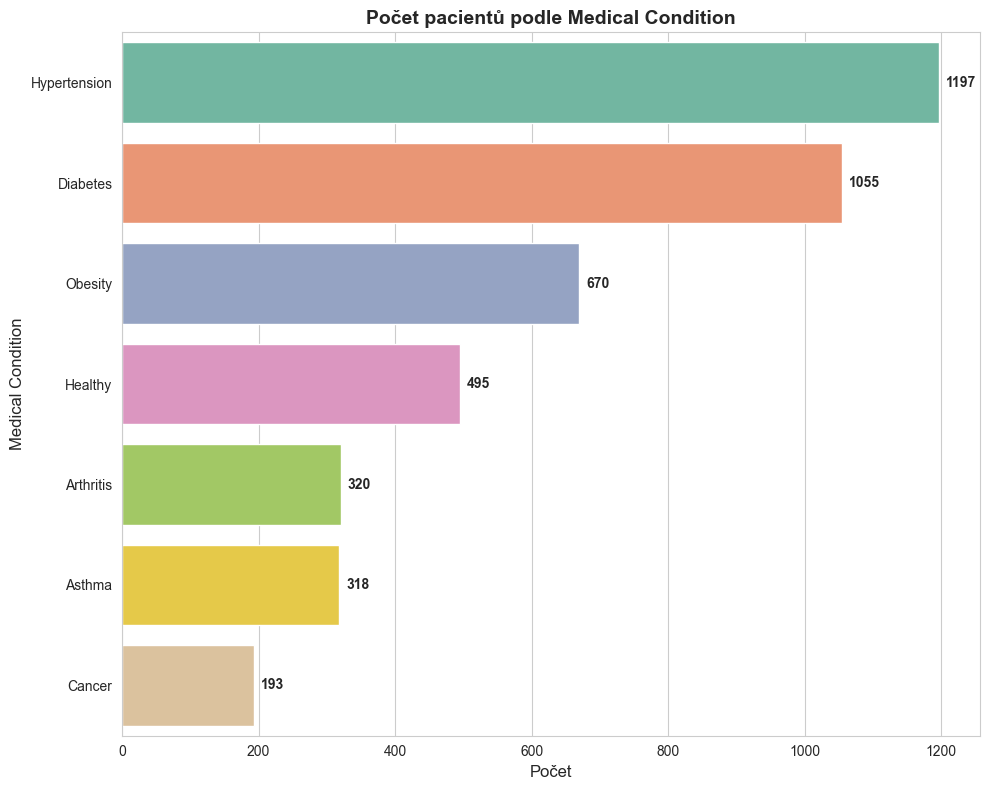

In [19]:
plt.figure(figsize=(10, 8))
condition_counts = df['Medical Condition'].value_counts()

sns.barplot(y=condition_counts.index, x=condition_counts.values, palette='Set2', orient='h')
plt.title('Počet pacientů podle Medical Condition', fontsize=14, fontweight='bold')
plt.xlabel('Počet', fontsize=12)
plt.ylabel('Medical Condition', fontsize=12)

# Přidej hodnoty na konec sloupců
for i, v in enumerate(condition_counts.values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Nejvíce rozšířenou chorobou v datasetu je Hypertenze a cukrovka, což se vzhledem k hodnotám krevního tlaku a cholesterolu dá čekat. Co mě nicméně překvapuje je to, že obezita se objevuje jen zhruba u pětiny datasetu, vzlášť když cukrovka je u čtvrtiny. Předpokládal jsem, že počet cukrovky a obezity bude velmi podobný, nicméně tomu tak není.

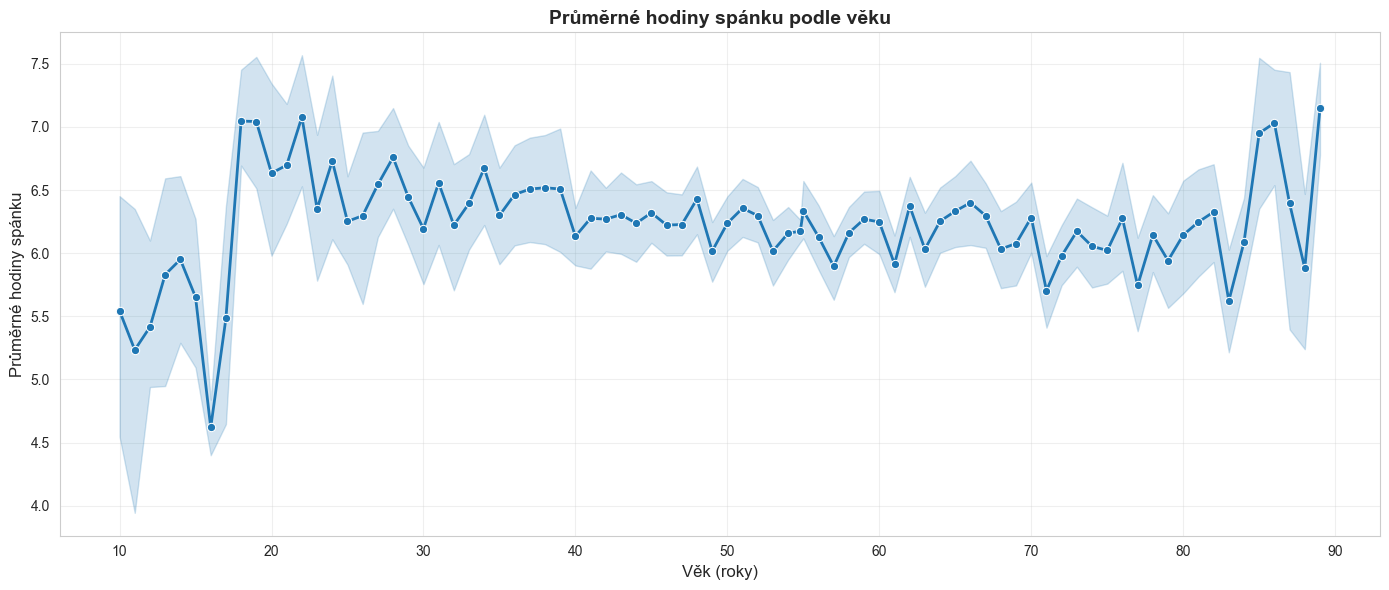

In [22]:
age_sleep = df.groupby('Age')['Sleep Hours'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Age', y='Sleep Hours', marker='o', linewidth=2, markersize=6)
plt.title('Průměrné hodiny spánku podle věku', fontsize=14, fontweight='bold')
plt.xlabel('Věk (roky)', fontsize=12)
plt.ylabel('Průměrné hodiny spánku', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Větší korelace mezi věkem a počtu odpsaných hodin není, nicméně skupina od 10 do 18 let má velmi málo odpsaných hodin, což může přispívat k nemoci.

C:\Users\ajrac\AppData\Local\Temp\ipykernel_21860\2844354680.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


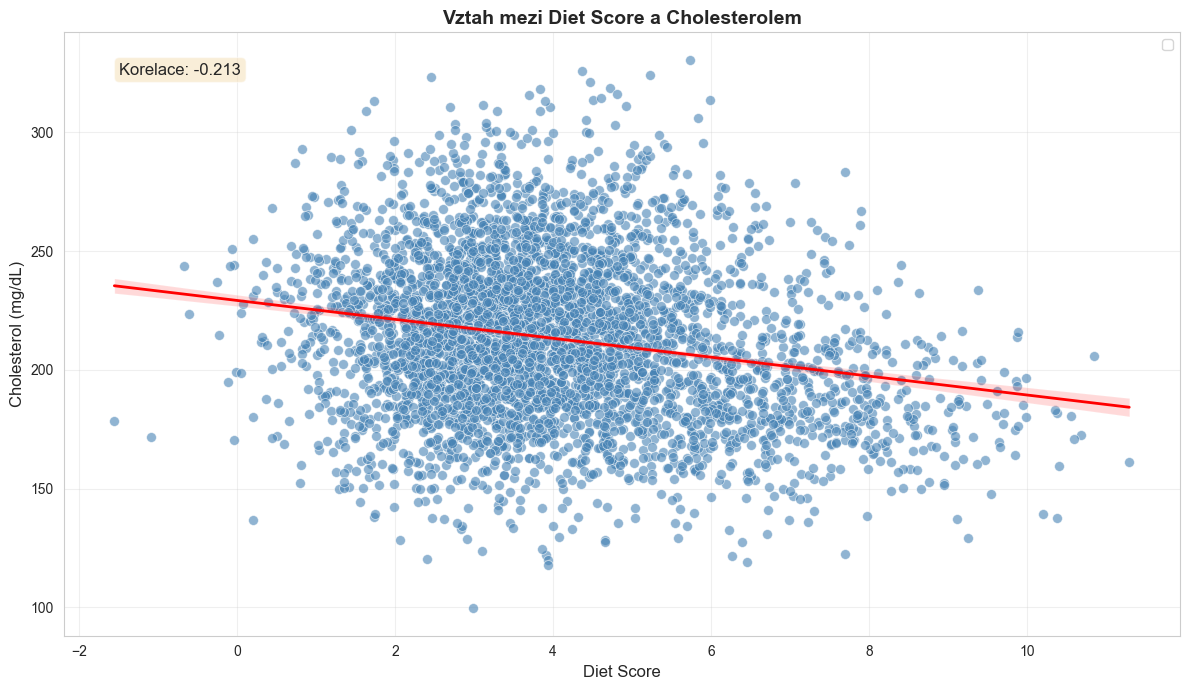

In [24]:
# Scatter plot - Diet Score vs Cholesterol
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='Diet Score', y='Cholesterol', alpha=0.6, s=50, color='steelblue')

# Přidej regresní čáru
sns.regplot(data=df, x='Diet Score', y='Cholesterol', scatter=False, color='red', 
            line_kws={'linewidth': 2, 'label': 'Regresní čára'})

plt.title('Vztah mezi Diet Score a Cholesterolem', fontsize=14, fontweight='bold')
plt.xlabel('Diet Score', fontsize=12)
plt.ylabel('Cholesterol (mg/dL)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Vypočítej a zobraz korelaci
correlation = df['Diet Score'].corr(df['Cholesterol'])
plt.text(0.05, 0.95, f'Korelace: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

C:\Users\ajrac\AppData\Local\Temp\ipykernel_21860\455044292.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


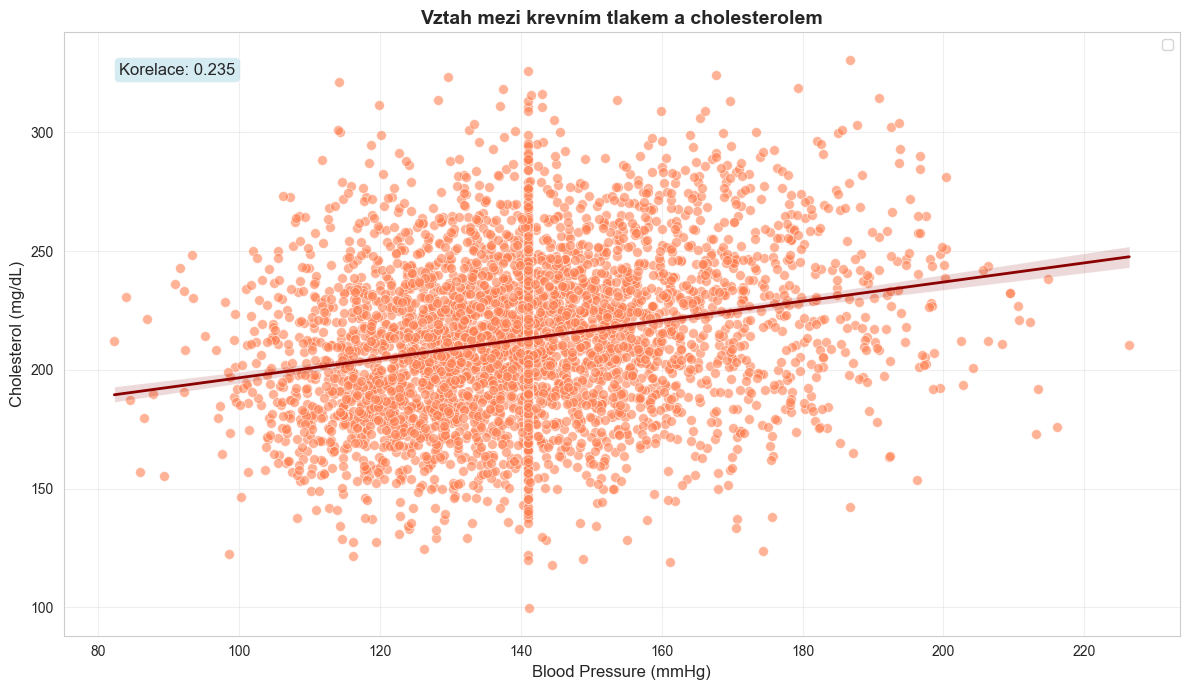

In [25]:
# Scatter plot - Blood Pressure vs Cholesterol
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='Blood Pressure', y='Cholesterol', alpha=0.6, s=50, color='coral')

# Přidej regresní čáru
sns.regplot(data=df, x='Blood Pressure', y='Cholesterol', scatter=False, color='darkred', 
            line_kws={'linewidth': 2, 'label': 'Regresní čára'})

plt.title('Vztah mezi krevním tlakem a cholesterolem', fontsize=14, fontweight='bold')
plt.xlabel('Blood Pressure (mmHg)', fontsize=12)
plt.ylabel('Cholesterol (mg/dL)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Vypočítej a zobraz korelaci
correlation = df['Blood Pressure'].corr(df['Cholesterol'])
plt.text(0.05, 0.95, f'Korelace: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

Zde jde vidět, že čím má člověk menší diet score, tím výšší má cholesterol.

A s tím souvisí i krevní tlak, čím vyšší je cholesterol, tím vyšší je krevní tlak.